In [1]:
import cv2
import os,sys
import numpy as np
from cellpose import utils, io, models, plot
from scipy import ndimage
from scipy import signal as sig
import re
import tools
import copy
import matplotlib.pyplot as plt
from scipy.ndimage import center_of_mass
import trackpy
import imageio.v2 as imageio
import pandas as pd

date = "30-03-2015"
my_data = "../data/" + date + "/Height/"
my_pfe = "../data/" + date + "/Peak_Force_Error/"
my_apm = "../data/" + date + "/Amplitude/"
my_sti = "../data/" + date + "/Stiffness/"
segments_path = "../cellpose_outputs/" + date + "/Height/"

In [2]:
# Load up a list of input files from our example data.
files = os.listdir(my_data)
for fichier in files[:]:
    if not(fichier.endswith(".png")):
        files.remove(fichier)
        
# Sort files by timepoint.
files.sort(key = tools.natural_keys)      

# Create a list that contains the full path to each of our image files. 
file_names = [my_data + file for file in files]

In [3]:
# Get the filenames for our segmentation datasets. 
segmented = os.listdir(segments_path)
for fichier in segmented[:]: 
    if not(fichier.endswith(".npy")):
        segmented.remove(fichier)

# Sort the filenames by timepoint. 
segmented.sort(key = tools.natural_keys)

# Create a list that records the timepoints for every image. 
time_list = []
for segment in segmented:
    time_list.append(int(re.findall(r'\d+', segment)[0]))

In [4]:
# Initialize lists.
outl_temp = []
height_img_list = []
stiff_img_list = []
pfe_img_list = []
areal_unfiltered = []
areal_filtered = []

# Fill lists with img and outline data from each segment
for segment, time in zip(segmented, time_list):
    # Load up the segmentation data. 
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    if len(dat['masks'])!=0:
        unique,counts=np.unique(dat['masks'],return_counts=True)
        areal_unfiltered= areal_unfiltered + list(counts[1:])
    # Remove small masks from the data
    dat["masks"] = utils.fill_holes_and_remove_small_masks(dat["masks"], min_size = 800)
    if len(dat['masks'])!=0:
        unique,counts=np.unique(dat['masks'],return_counts=True)
        areal_filtered = areal_filtered + list(counts[1:])
    # Populate list with each cell outline.
    outl = utils.outlines_list(dat['masks'])
    outl_temp.append(outl)
    
    # Populate list with each original image.
    image = dat["img"]
    height_img_list.append(image)
    
    # If it exists, read in the png with the stiffness and PFE.
    if os.path.exists(my_sti + str(time) + "_Stiffness.png") == True:
        stiff_img_list.append(imageio.imread(my_sti + str(time) + "_Stiffness.png"))
    else:
        stiff_img_list.append(np.nan)
        
    if os.path.exists(my_pfe + str(time) + "_PFE.png") == True:
        pfe_img_list.append(imageio.imread(my_pfe + str(time) + "_PFE.png"))
    else:
        pfe_img_list.append(np.nan)

In [5]:
# The image dictionary contains the complete images for all of the image types. 
img_dict = {
    "Height": height_img_list,
    "Stiffness": stiff_img_list,
    "PFE": pfe_img_list
    }
# The metadata dictionary will hold all of the data we want to save into our final table.
metadata_dict = {}

# The individual cell dictionary will save information for each individual cell such as the outline, skeleton, cropped image, etc. 
ind_cell_dict = {}

# The structural dictionary will hold information on the timepoint of each image, the cell IDs for each cell in each image,
# and the outlines and bounding boxes for each cell in each image.
structural_dict = {
    "Time": time_list
    }

In [6]:
# Initialize a list of boxes
boxes_temp = []
box_img = copy.deepcopy(height_img_list)

# Fill lists with the coordinates of bounding boxes for each cell outline.
for outl, img in zip(outl_temp, box_img):
    boxes = tools.get_boxes(outl)
    boxes_temp.append(boxes)
    for box in boxes:
        (startX, startY, endX, endY) = box.astype("int")
        cv2.drawContours(img, [box.astype("int")], -1, (0, 255, 0), 2)

In [7]:
# initialize our centroid tracker and frame dimensions
ct = tools.CentroidTracker()
(H, W) = (None, None)

# Initialize a new set of lists that will contain lists of IDs, outlines, and centers for each image file. 
IDs_list = []
outl_list = []
boxes_list = []
centers_list = []

# loop over the outlines and boxes for each file.
for boxes, img, outls in zip(boxes_temp, box_img, outl_temp):
    # update our centroid tracker using the computed set of bounding box rectangles
    if len(outls)!=0:
        objects = ct.update(boxes, outls)
    # Initialize a new set of lists
    IDs = []
    outl_new = []
    boxes_new = []
    centers = []
    # loop over the tracked objects
    if len(outls)!=0:
        for (objectID, info) in objects.items():
            # draw both the ID of the object and the centroid of the
            # object on the output frame
            text = "ID {}".format(objectID)
            cv2.putText(img, text, (info[1][0] - 10, info[1][1] - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            cv2.circle(img, (info[1][0], info[1][1]), 4, (0, 255, 0), -1)
            # append the object ID and its associated outline and center to the lists. 
            IDs.append(objectID)
            outl_new.append(info[2])
            centers.append(info[1])
            boxes_new.append(info[0])
    boxes_list.append(boxes_new)
    IDs_list.append(IDs)
    outl_list.append(outl_new)
    centers_list.append(centers)

In [8]:
# Add our new lists to the proper dictionaries. 
structural_dict["IDs"] = IDs_list
structural_dict["outlines"] = outl_list
structural_dict["bounding_boxes"] = boxes_list

metadata_dict["centroids"] = centers_list

# Destroy the temporary lists to get some more space. 
boxes_temp.clear()
outl_temp.clear()

In [9]:
ind_cell_dict = {}
ind_cell_dict["Height"], ind_cell_dict["Mask"] = tools.extract_ind_cells(IDs_list, outl_list, img_dict["Height"])

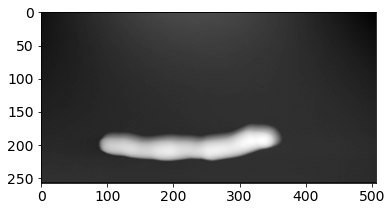

In [23]:
img0 = img_dict['Height'][0][:,:-100,0]
img0_normalized = (img0-np.average(img0))/np.std(img0)
img1 = img_dict['Height'][1][:,:-100,0]
img1_normalized = (img1-np.average(img1))/np.std(img1)
img2 = img_dict['Height'][2][:,:-100,0]
img2_normalized = (img2-np.average(img2))/np.std(img2)
plt.imshow(img2,cmap=plt.cm.gray)

In [28]:
cor0=sig.correlate(img0_normalized,img0_normalized)
cor1=sig.correlate(img1_normalized,img0_normalized)
M0 = np.array(np.where(cor0 == cor0.max())).T[0]
M1 = np.array(np.where(cor1 == cor1.max())).T[0]
M1-M0

array([5, 0])

In [30]:
cor0=sig.correlate(img1_normalized,img1_normalized)
cor1=sig.correlate(img2_normalized,img1_normalized)
M0 = np.array(np.where(cor0 == cor0.max())).T[0]
M1 = np.array(np.where(cor1 == cor1.max())).T[0]
M1-M0 + np.array([5,0])

array([ 42, -22])

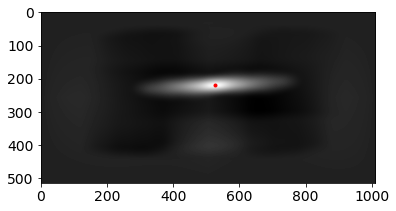

In [17]:
M = np.array(np.where(cor == cor.max())).T[0]
plt.imshow(cor,cmap=plt.cm.gray)
plt.plot(M[1],M[0],'r.')

In [22]:
M-np.array(img0.shape)

array([-38,  21])

In [61]:
centerl_aligned = []
for (img,centers) in zip(img_dict['Height'],metadata_dict['centroids']):
    if img.shape[0]<514:
        newl = [c + np.array([0,128]) for c in centers]
        centerl_aligned.append(newl)
    else:
        centerl_aligned.append(centers)

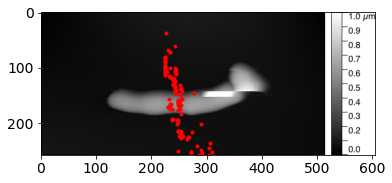

In [63]:
for centers in centerl_aligned:
    for center in centers:
        plt.plot(center[1],center[0],'r.')
plt.imshow(img_dict['Height'][0])

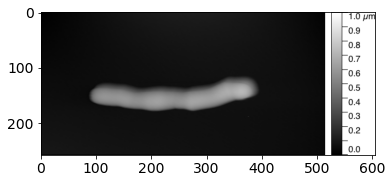

In [101]:
img=img_dict['Height'][6]
plt.imshow(img)

In [102]:
tranl = []
dat = np.load(segments_path + segmented[0], allow_pickle=True).item()
com0 = np.array(center_of_mass(dat['masks']>0))
for segment in segmented:
    dat = np.load(segments_path + segment, allow_pickle=True).item()
    com = np.array(center_of_mass(dat['masks']>0))
    tran = (com-com0)//1
    tranl.append(tran)

In [70]:
[y,x]=np.transpose(np.array(tranl))

In [71]:
lpad0 = int(max(x))
if lpad0<=0:
    lpad0 = 0
rpad0 = int(min(x))
if rpad0>=0:
    rpad0 = 0
else:
    rpad0 = abs (rpad0)
tpad0 = int(max(y))
if tpad0<=0:
    tpad0 =0
bpad0 = int(min(y))
if bpad0>=0:
    bpad0 = 0
else:
    bpad0 = abs(bpad0)

In [107]:
centerl_aligned = []
for tran, seg,centers in zip(tranl,segmented,metadata_dict['centroids']):
    aligned=[cen + tran for cen in centers]
    centerl_aligned.append(aligned)

In [108]:
C = pd.DataFrame(columns=['frame','y','x'])
for i in range(0,len(centerl_aligned[:7])):
    for center in centerl_aligned[i]:
        df2=pd.DataFrame({'frame':[i],'y':[center[0]],'x':[center[1]]})
        C = pd.concat([C,df2],ignore_index=True, axis=0)

In [113]:
tranl[:7]

[array([0., 0.]),
 array([ 13., -16.]),
 array([49., 19.]),
 array([ 34., -14.]),
 array([27., 11.]),
 array([  6., -25.]),
 array([   4., -109.])]

In [111]:
P = trackpy.link(C,40,memory=3)
pf = trackpy.filter_stubs(P,20)

Frame 6: 1 trajectories present.


In [112]:
P

,frame,y,x,particle
0,0,375.0,118.0,0
1,0,339.0,144.0,1
2,0,202.0,162.0,2
3,1,261.0,145.0,3
4,2,331.0,216.0,4
5,3,286.0,168.0,3
6,4,307.0,186.0,3
7,5,247.0,129.0,5
8,6,149.0,41.0,6


In [79]:
np.unique(pf['particle'].to_numpy())

array([], dtype=int64)

In [50]:
cells = ['7','6','5','8','4','12']

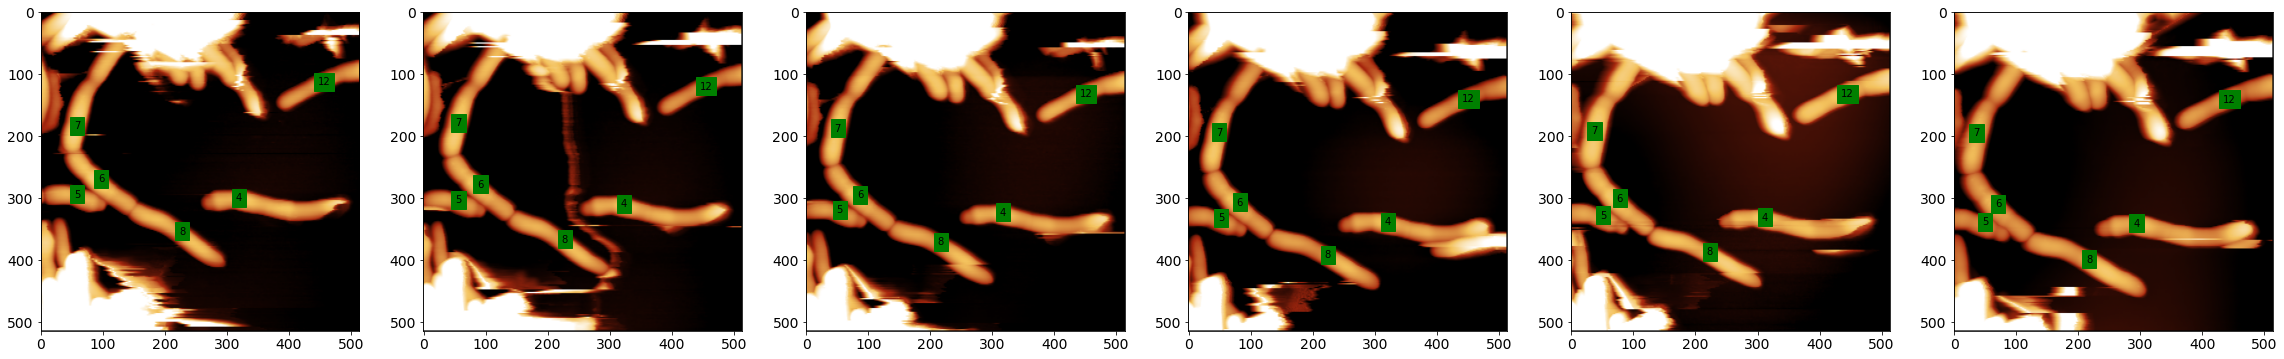

In [51]:
fig,axs = plt.subplots(1,6,figsize=(40,10))
for row in P.iterrows():
    i = row[1]['frame']
    y = row[1]['y']
    x = row[1]['x']
    label = str(row[1]['particle'])
    if label in cells:
        axs[i].imshow(img_dict['Height'][i])
        axs[i].text(y,x,label,backgroundcolor='g')

In [41]:
pf2 = pf.iloc[0:11]

In [42]:
y=pf2['y'].to_numpy()
x=pf2['x'].to_numpy()
label = [str(i) for i in pf2['particle'].to_numpy()]

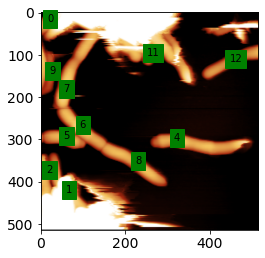

In [43]:
plt.imshow(img_dict['Height'][0])
for row in pf2.iterrows():
    y = row[1]['y']
    x = row[1]['x']
    label = str(row[1]['particle'])
    plt.text(y,x,label,backgroundcolor='g')